### Step 1: Import libraries

In [1]:
import os, warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.preprocessing import QuantileTransformer, RobustScaler
from sklearn.cluster import DBSCAN
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
try:
    from tensorflow.keras.models import Model
    from tensorflow.keras.layers import Input, Dense
    from tensorflow.keras.callbacks import EarlyStopping
    KERAS_AVAILABLE = True
except Exception:
    from sklearn.neural_network import MLPRegressor
    KERAS_AVAILABLE = False
import matplotlib.pyplot as plt
import seaborn as sns

### Step 2: Load dataset 

In [2]:
df = pd.read_csv(r"C:\Users\teste\Downloads\Salary_Dataset_with_Extra_Features.csv.zip")
print("Dataset Shape:", df.shape)

Dataset Shape: (22770, 8)


In [3]:
df.head()

,Rating,Company Name,Job Title,Salary,Salaries Reported,Location,Employment Status,Job Roles
0,3.8,Sasken,Android Developer,400000,3,Bangalore,Full Time,Android
1,4.5,Advanced Millennium Technologies,Android Developer,400000,3,Bangalore,Full Time,Android
2,4.0,Unacademy,Android Developer,1000000,3,Bangalore,Full Time,Android
3,3.8,SnapBizz Cloudtech,Android Developer,300000,3,Bangalore,Full Time,Android
4,4.4,Appoids Tech Solutions,Android Developer,600000,3,Bangalore,Full Time,Android


### step 3: Numeric features selection

In [4]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if len(num_cols) == 0:
    raise ValueError("No numeric columns detected. This pipeline focuses on numeric features for outlier detection.")
print("Numeric columns:", num_cols)
df_work = df.copy()

Numeric columns: ['Rating', 'Salary', 'Salaries Reported']


### step  4: Robust imputation for missing values

In [5]:
imputer = KNNImputer(n_neighbors=5, weights="distance")   # better than median for advanced imputation
X_num = imputer.fit_transform(df_work[num_cols])
num_df_imputed = pd.DataFrame(X_num, columns=num_cols, index=df_work.index)

### step 5: Robust feature transform 

In [6]:
qt = QuantileTransformer(output_distribution='normal', n_quantiles=min(1000, max(100, X_num.shape[0]//2)), random_state=42)
X_qt = qt.fit_transform(X_num)
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X_qt)

### step 6: Autoencoder

In [16]:
if KERAS_AVAILABLE:
    dim = X_scaled.shape[1]
    # small symmetric autoencoder architecture (adjust depth/width if needed)
    inp = Input(shape=(dim,))
    x = Dense(max(16, dim*2), activation='relu')(inp)
    x = Dense(max(8, dim), activation='relu')(x)
    bottleneck = Dense(max(4, dim//2), activation='relu')(x)
    x = Dense(max(8, dim), activation='relu')(bottleneck)
    x = Dense(max(16, dim*2), activation='relu')(x)
    out = Dense(dim, activation='linear')(x)
    autoenc = Model(inp, out)
    autoenc.compile(optimizer='adam', loss='mse')

    es = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
    history = autoenc.fit(X_scaled, X_scaled,
                          epochs=30,
                          batch_size=64,
                          validation_split=0.10,
                          callbacks=[es],
                          verbose=1)
    recon = autoenc.predict(X_scaled)
    errors = np.mean(np.square(recon - X_scaled), axis=1)
else:
    # fallback: use an MLP regressor as a simple autoencoder (works if keras missing)
    mlp = MLPRegressor(hidden_layer_sizes=(max(50, X_scaled.shape[1]*2), max(20, X_scaled.shape[1])),
                       max_iter=600, random_state=42)
    mlp.fit(X_scaled, X_scaled)
    recon = mlp.predict(X_scaled)
    errors = np.mean((recon - X_scaled)**2, axis=1)

# robust threshold for reconstruction error using median + MAD
med = np.median(errors)
mad = np.median(np.abs(errors - med)) + 1e-12
ae_threshold = med + 6 * mad    # 6*MAD is conservative; lower -> more anomalies
ae_anomaly = errors > ae_threshold

print(f"Autoencoder anomalies detected: {ae_anomaly.sum()} (threshold={ae_threshold:.6g})")

Epoch 1/30
321/321 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 1.8445 - val_loss: 0.2103
Epoch 2/30
321/321 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1955 - val_loss: 0.0497
Epoch 3/30
321/321 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0256 - val_loss: 0.0119
Epoch 4/30
321/321 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0075 - val_loss: 0.0079
Epoch 5/30
321/321 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0038 - val_loss: 0.0046
Epoch 6/30
321/321 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0026 - val_loss: 0.0042
Epoch 7/30
321/321 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0021 - val_loss: 0.0031
Epoch 8/30
321/321 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0016 - val_loss: 0.0029
Epoch 9/30
321/321 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0014 - val_loss: 0.0023
Epoch 10/30
321/321 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0012 - val_loss: 0.0036
Epoch 11/30
321/321 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0011 - val_loss: 0.0017
Epoch 12/30
321/321 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

### step 7: DBSCAN density based anomalies

In [8]:
min_samples = max(5, int(0.01 * len(df_work)))  # 1% of dataset or 5
db = DBSCAN(eps=0.5, min_samples=min_samples, metric='euclidean', n_jobs=-1)
db_labels = db.fit_predict(X_scaled)
db_anomaly = (db_labels == -1)
print(f"DBSCAN anomalies detected: {db_anomaly.sum()} (min_samples={min_samples})")

DBSCAN anomalies detected: 1036 (min_samples=227)


### step 8: Combine detectors

In [9]:
combined_high_confidence = ae_anomaly & db_anomaly
combined_union = ae_anomaly | db_anomaly
print("High-confidence anomalies (both AE & DBSCAN):", combined_high_confidence.sum())
print("Union anomalies (AE or DBSCAN):", combined_union.sum())
anomaly_mask = combined_high_confidence

High-confidence anomalies (both AE & DBSCAN): 310
Union anomalies (AE or DBSCAN): 4120


### step 9 : Predictive imputation: for each numeric column train a regressor on non-anomalous rows

In [10]:
df_clean = df_work.copy()
# We will perform predictions on original imputed numeric values (num_df_imputed) which are in original scale
for col in num_cols:
    out_idx = num_df_imputed.index[anomaly_mask]
    if len(out_idx) == 0:
        continue  # nothing to fix
    train_idx = num_df_imputed.index[~anomaly_mask]
    # predictors: all other numeric columns
    Xtrain = num_df_imputed.loc[train_idx].drop(columns=[col])
    ytrain = num_df_imputed.loc[train_idx, col]
    Xpred  = num_df_imputed.loc[out_idx].drop(columns=[col])
    # quick check
    if Xtrain.shape[0] < 50:
        # small training set: use simple median replacement instead of heavy modeling
        median_val = np.median(ytrain)
        df_clean.loc[out_idx, col] = median_val
        print(f"Column {col}: small training data ({Xtrain.shape[0]} rows). Used median imputation = {median_val:.4g}")
        continue

    # fit gradient boosting regressor (robust, handles non-linearities)
    gbr = GradientBoostingRegressor(n_estimators=200, max_depth=4, learning_rate=0.05, random_state=42)
    gbr.fit(Xtrain, ytrain)
    preds = gbr.predict(Xpred)
    # write back predictions to cleaned df
    df_clean.loc[out_idx, col] = preds
    print(f"Column {col}: replaced {len(out_idx)} anomalous rows with model predictions.")

Column Rating: replaced 310 anomalous rows with model predictions.
Column Salary: replaced 310 anomalous rows with model predictions.
Column Salaries Reported: replaced 310 anomalous rows with model predictions.


### step 10: Final winsorization to clip any remaining extremes 

In [11]:
for col in num_cols:
    low_q, high_q = df_clean[col].quantile([0.01, 0.99]).tolist()
    df_clean[col] = df_clean[col].clip(lower=low_q, upper=high_q)

### step 11: Save cleaned file

In [12]:
out_path = "/mnt/data/Salary_Dataset_with_Extra_Features_cleaned.csv"
df_clean.to_csv(out_path, index=False)
print("Saved cleaned dataset to:", out_path)
display(df_clean.head())

Saved cleaned dataset to: /mnt/data/Salary_Dataset_with_Extra_Features_cleaned.csv


,Rating,Company Name,Job Title,Salary,Salaries Reported,Location,Employment Status,Job Roles
0,3.8,Sasken,Android Developer,400000.0,3.0,Bangalore,Full Time,Android
1,4.5,Advanced Millennium Technologies,Android Developer,400000.0,3.0,Bangalore,Full Time,Android
2,4.0,Unacademy,Android Developer,1000000.0,3.0,Bangalore,Full Time,Android
3,3.8,SnapBizz Cloudtech,Android Developer,300000.0,3.0,Bangalore,Full Time,Android
4,4.4,Appoids Tech Solutions,Android Developer,600000.0,3.0,Bangalore,Full Time,Android


### step 12: Visual Diagnostics for Outlier Handling

### A) Autoencoder reconstruction error distribution

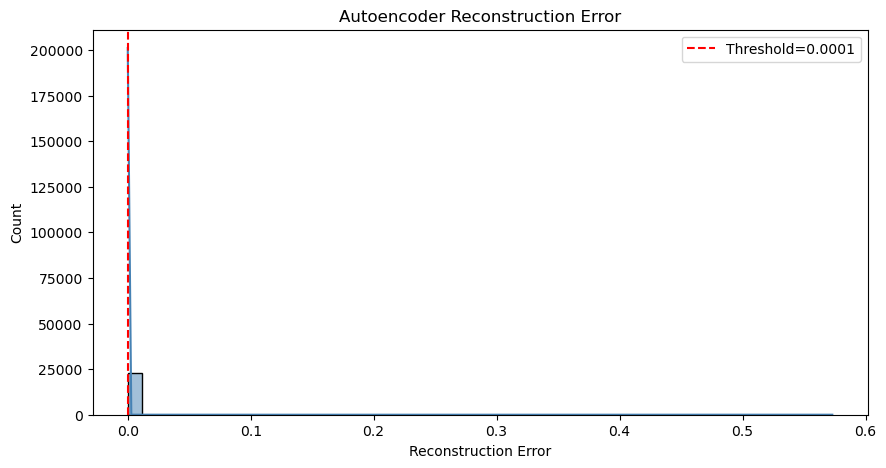

In [13]:
plt.figure(figsize=(10,5))
sns.histplot(errors, bins=50, kde=True, color="steelblue")
plt.axvline(ae_threshold, color="red", linestyle="--", label=f"Threshold={ae_threshold:.4f}")
plt.title("Autoencoder Reconstruction Error")
plt.xlabel("Reconstruction Error")
plt.ylabel("Count")
plt.legend()
plt.show()

### B) DBSCAN clustering (2D PCA projection)

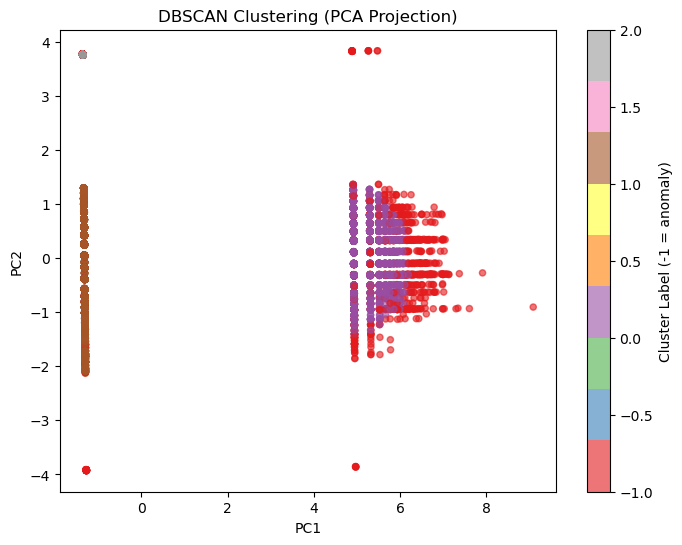

In [14]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=db_labels, cmap="Set1", s=20, alpha=0.6)
plt.title("DBSCAN Clustering (PCA Projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label="Cluster Label (-1 = anomaly)")
plt.show()

### C) Before vs After boxplots for a key column (example: Salary)

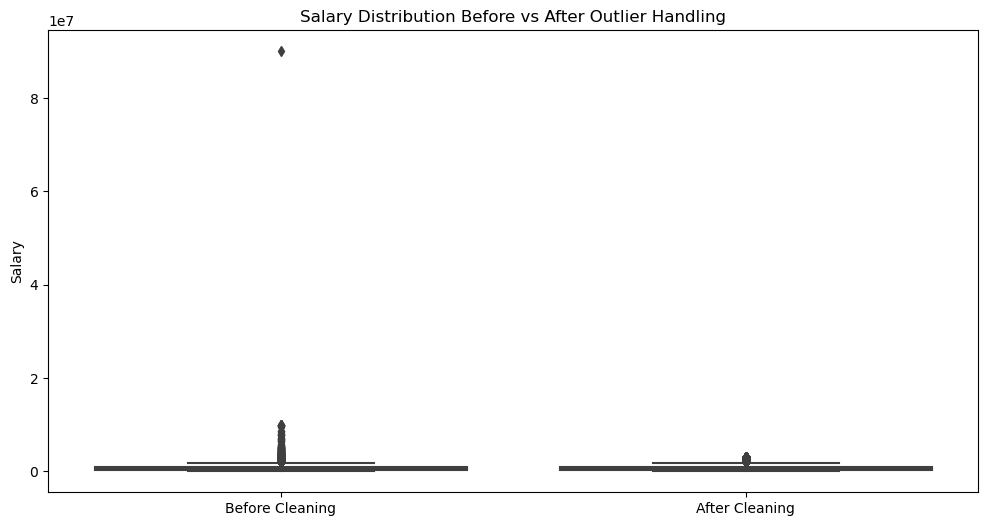

In [15]:
if "Salary" in num_cols:
    plt.figure(figsize=(12,6))
    sns.boxplot(data=[df["Salary"], df_clean["Salary"]])
    plt.xticks([0,1], ["Before Cleaning", "After Cleaning"])
    plt.title("Salary Distribution Before vs After Outlier Handling")
    plt.ylabel("Salary")
    plt.show()

### D) Outlier detection summary

In [17]:
print("Outlier Detection Summary:")
print(f"Autoencoder anomalies: {ae_anomaly.sum()}")
print(f"DBSCAN anomalies: {db_anomaly.sum()}")
print(f"High-confidence (AE & DBSCAN): {combined_high_confidence.sum()}")
print(f"Union anomalies (AE or DBSCAN): {combined_union.sum()}")

Outlier Detection Summary:
Autoencoder anomalies: 2739
DBSCAN anomalies: 1036
High-confidence (AE & DBSCAN): 310
Union anomalies (AE or DBSCAN): 4120
